# Functions to get synthetic data and plot values for priv and non priv cases

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_regression
import math
from sklearn.preprocessing import normalize
import pylab
from scipy.stats import spearmanr

def genData(mu, sigma, n, d):
    
    for i in range(n):
    
        x = np.random.normal(mu, sigma, size=d).reshape(1,d)
        if i%2000 == 0:
            print(i/2000)
        if i==0:
            temp=x
        else:
            temp = np.append(arr=X, values=x, axis=0)

        while np.std(temp) > sigma:
        
            x = np.random.normal(mu, sigma, size=d).reshape(1,d)
            if i==0:
                temp=x
            elif i>0:
                temp = np.append(arr=X, values=x, axis=0)

        x = x.reshape(1,d)
        if i == 0:
            X = x
        elif i>0:
            X = np.append(arr=X, values=x, axis=0)
        
#     print("STD of X is:", np.std(X))
#     print("X:\n", X)

    w = np.random.uniform(low=0.0, high=1.0, size=d).reshape(d,1)
    b = np.random.normal(0, 1, size=n).reshape(n)
#     print("b:\n", b)
#     print("w:\n",w)
    y = np.matmul(X, w).reshape(n) 
#     y = y+b
#     print("y:\n",y)
    return X,y



In [41]:
def l1norm_X_and_y_preserve_linearity(X, y, val):
    
    n = X.shape[0]
    d = X.shape[1]
    for i in range(n):
        row_abs_sum = sum(abs(X[i, :]))
        X[i] = X[i]/row_abs_sum
        if val == 1:
            y[i] = y[i]/row_abs_sum
        else:
            ymax = max(abs(y))
            y = y/ymax

    return X, y


def priv_plotter(X, y, n, d, k, epsilon, jump, rep, apply_u, apply_v):
    
    X = X[:n, :d]
    y = y[:n]
    
#     rep = 10
    elems = math.floor(((d+2)/2)*(d+1))
    split_val = math.floor(n/5)
    m = math.floor((n-split_val)/jump)
    
    X = np.append(arr=np.ones((n,1)), values=X, axis=1)
    
#     X = minimax_normalise(X)
#     y = minimax_normalise(y.reshape(1, n)).reshape(n)
    X, y = l1norm_X_and_y_preserve_linearity(X,y,0)
    # range of X and y is -1 to 1

    RMSE = np.zeros((k, m))
    priv_RMSE = np.zeros((k, m))
    X_val = np.zeros((m))
    p_corr_rank = np.zeros((m))
    np_corr_rank = np.zeros((m))

    for i in range(k):
    
        X_test = X[i*split_val:(i+1)*split_val, :]
        y_test = y[i*split_val:(i+1)*split_val]
    
        X_without_XTest = X[:i*split_val, :]
        X_without_XTest = np.append(arr=X_without_XTest, values=X[(i+1)*split_val:, :], axis=0)
    
        y_without_yTest = y[:i*split_val]
        y_without_yTest = np.append(arr=y_without_yTest, values=y[(i+1)*split_val:], axis=0)
    
        for j in range(m):
            X_val[j] = math.floor((j+1)*jump)
            train_size = math.floor((j+1)*jump)
            X_train = X_without_XTest[:train_size, :]
            y_train = y_without_yTest[:train_size]
        
            xT = X_train.transpose()
            xTx = np.matmul(xT, X_train)
            xTx_pinv = np.linalg.pinv(xTx)
            xTy = np.matmul(xT, y_train)
            w = np.matmul(xTx_pinv, xTy)
        
            priv_RMSE_per_lpl = np.zeros((rep))
            
            T_per_rep = np.ones((y_test.shape[0],0))
            
#             print("xTx at :", X_train.shape[0] ," \n", xTx, "\nxTy at:", X_train.shape[0] ,"\n", xTy, "\n")
        
            for l in range(rep):
                b1 = elems/(epsilon)
                b2 = d/epsilon
            
                u_mirr = np.random.laplace(loc=0.0, scale=b1, size = elems)
                
                pos = 0
                u = np.ones((d+1, d+1))
                for r in range(d+1):
                    for c in range(r, d+1):
                        u[c][r] = u_mirr[pos]
                        u[r][c] = u[c][r]
                        pos = pos+1
                v = np.random.laplace(loc=0.0, scale=b2, size = d+1)
            
                sTs = xTx 
                sTt = xTy 
                if apply_u == 1:
                    sTs = xTx + u
                if apply_v == 1:
                    sTt = xTy + v
                sTs_pinv = np.linalg.pinv(sTs)
                wi = np.matmul(sTs_pinv, sTt)
                T = np.matmul(X_test, wi)
                
#                 print("\nu at epsilon",epsilon,":\n", u, "xTy:\n", xTy, "v at epsilon",epsilon,":\n", v)
                
                if l == 0:
                    T_per_rep = T.reshape(T.shape[0], 1)
                
                else:
                    T_per_rep = np.append(arr=T_per_rep, values=T.reshape(T.shape[0], 1), axis=1)
                
                priv_RMSE_per_lpl[l] = np.mean(abs(T-y_test)**2)**0.5

            T_avg = sum(T_per_rep.transpose())/rep
            
            corr, p_val = spearmanr(T_avg, y_test)
            p_corr_rank[j] = corr
            
            priv_RMSE[i][j] = np.mean(priv_RMSE_per_lpl)
            y_pred = np.matmul(X_test, w)
            corr, p_val = spearmanr(y_pred, y_test)
            np_corr_rank[j] = corr
            RMSE[i][j] = np.mean(abs(y_pred-y_test)**2)**0.5

    total_RMSE = sum(RMSE)/k
    priv_total_RMSE = sum(priv_RMSE)/k

    RMSE_SD = np.zeros((m))
    priv_RMSE_SD = np.zeros((m))
    for i in range(m):
        RMSE_SD[i] = RMSE[:, i:i+1].std()
        priv_RMSE_SD[i] = priv_RMSE[:, i:i+1].std()

    ans = np.zeros((7,m))
    ans[0] = X_val
    ans[1] = priv_total_RMSE
    ans[2] = priv_RMSE_SD
    ans[3] = total_RMSE
    ans[4] = RMSE_SD
    ans[5] = p_corr_rank
    ans[6] = np_corr_rank

    return ans


def np_plotter(X, y, n, d, k, jump):
    
    X = X[:n, :d]
    y = y[:n]
    
    rep = 10
    elems = math.floor(((d+2)/2)*(d+1))
    split_val = math.floor(n/5)
    m = math.floor((n-split_val)/jump)
    
    X = np.append(arr=np.ones((n,1)), values=X, axis=1)

    X, y = l1norm_X_and_y_preserve_linearity(X,y,0)

    RMSE = np.zeros((k, m))
    X_val = np.zeros((m))
    np_corr_rank = np.zeros((m))

    for i in range(k):
    
        X_test = X[i*split_val:(i+1)*split_val, :]
        y_test = y[i*split_val:(i+1)*split_val]
    
        X_without_XTest = X[:i*split_val, :]
        X_without_XTest = np.append(arr=X_without_XTest, values=X[(i+1)*split_val:, :], axis=0)
    
        y_without_yTest = y[:i*split_val]
        y_without_yTest = np.append(arr=y_without_yTest, values=y[(i+1)*split_val:], axis=0)
    
        for j in range(m):
            X_val[j] = math.floor((j+1)*jump)
            train_size = math.floor((j+1)*jump)
            X_train = X_without_XTest[:train_size, :]
            y_train = y_without_yTest[:train_size]
        
            xT = X_train.transpose()
            xTx = np.matmul(xT, X_train)
            xTx_pinv = np.linalg.pinv(xTx)
            xTy = np.matmul(xT, y_train)
            w = np.matmul(xTx_pinv, xTy)
        
            y_pred = np.matmul(X_test, w)
            corr, p_val = spearmanr(y_pred, y_test)
            np_corr_rank[j] = corr
            RMSE[i][j] = np.mean(abs(y_pred-y_test)**2)**0.5

    total_RMSE = sum(RMSE)/k

    RMSE_SD = np.zeros((m))

    for i in range(m):
        RMSE_SD[i] = RMSE[:, i:i+1].std()

    ans = np.zeros((4,m))
    ans[0] = X_val
    ans[1] = total_RMSE
    ans[2] = RMSE_SD
    ans[3] = np_corr_rank

    return ans

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_regression
import math
from sklearn.preprocessing import normalize
import pylab
from scipy.stats import spearmanr

mu=0
sigma=1
apply_u = 1
apply_v = 1
n = 100000
d = 10
k = 5
eps = [1,2,5]
pts = 10
rep = 50
jump = math.floor(n/pts)

# X, y = make_regression(n_samples = n, n_features = d, noise=30)
X,y = genData(mu, sigma, n, d)
colors = ["blue", "red", "black", "orange", "green"]

y_axis = np.ones((len(eps)))

for eps_idx in range(len(eps)):
    epsilon = eps[eps_idx]
    ans = priv_plotter(X, y, n, d, k, epsilon, jump, rep, 1, 1)
    print("eps")
    y_axis[eps_idx] = ans[5][ans.shape[1]-1]
    plt.errorbar(ans[0], ans[1], color=colors[eps_idx], ecolor=colors[eps_idx], capsize=3, label='ε '+str(epsilon), errorevery=5)
    
plt.errorbar(ans[0], ans[3], color="green", ecolor="green", capsize=3, label='NP')    
plt.rcParams['figure.figsize'] = (7, 7)
plt.xlabel("Training set size")
plt.ylabel("RMSE")
pylab.legend(loc='upper right')
plt.title("Train set size vs RMSE for k-fold cross validation")
plt.show()

# plt.rcParams['figure.figsize'] = (15, 5)

# plt.subplot(1,2,1)
# plt.xlabel("Training set size")
# plt.ylabel("Spearmans rank corr coeff")
# plt.title("Train set size vs Spearman's rank corr coeff")
# plt.plot(ans[0], ans[5], label='eps 0.75')
# plt.plot(ans[0], ans[6])

# plt.subplot(1,2,2)
# plt.plot(eps, y_axis)
# plt.xlabel("Privacy budget")
# plt.ylabel("Spearmans rank corr coeff")
# plt.title("privacy budget vs Spearman's rank corr coeff for eps 1.5")
# plt.tight_layout()
# plt.show()



2000
2000
2000
2000
2000
2000
2000
2000
2000


KeyboardInterrupt: 

# Get data 

In [42]:
# Get synthetic data

mu=0
sigma=1

entries = [200000]
features = [100]

n = entries[len(entries)-1]
d = features[len(features)-1]

X,y = genData(mu, sigma, n, d)
print("Done")
colors = ["blue", "red", "black", "orange", "green"]

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
Done


In [43]:
print(X.shape)

(200000, 100)


# Training size vs RMSE

eps1
eps2
feat1


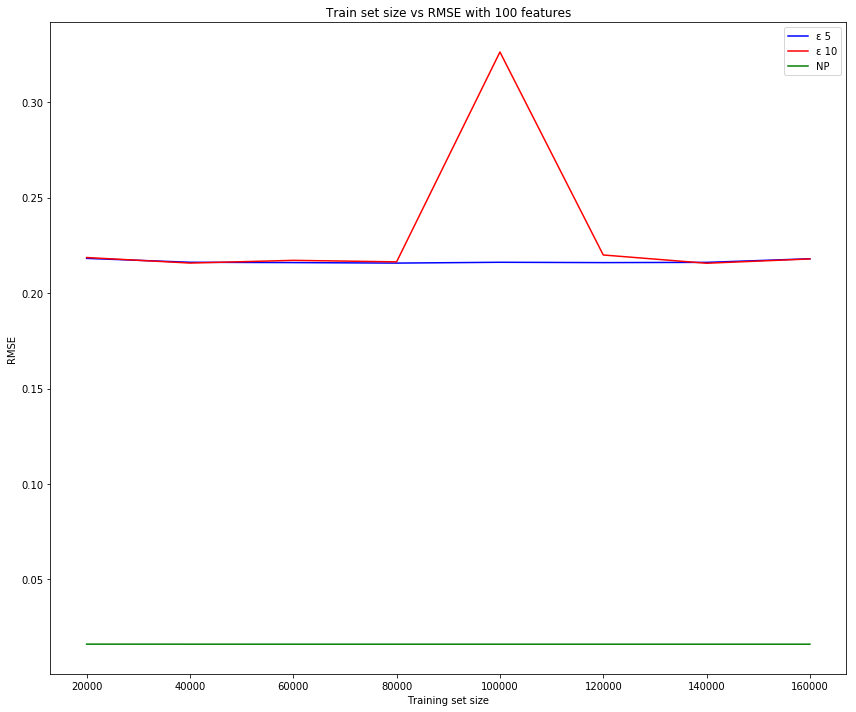

In [44]:
plotnum = 1
entries = [200000]
features = [100]
k = 5
eps = [5, 10]
plotnum = 1
pts = 10

plt.rcParams['figure.figsize'] = (12,10)

x_priv_plots_without_DR = np.ones((0,pts))
y_priv_plots_without_DR = np.ones((0,pts))

for i in range(len(entries)):
    n = entries[i]
    jump = math.floor(n/pts)
    for j in range(len(features)):
        d = features[j]
        plt.rcParams['figure.figsize'] = (12,10)
        plt.subplot(len(entries),len(features),plotnum)
        for eps_idx in range(len(eps)):
            epsilon = eps[eps_idx]
            ans = priv_plotter(X, y, n, d, k, epsilon, jump, 10, 1, 1)
            
            if epsilon==5:
                ans_withoutDR_e5 = ans
            if epsilon==10:
                ans_withoutDR_e10 = ans
            
            print("eps"+str(eps_idx+1))
            plt.errorbar(ans[0], ans[1], color=colors[eps_idx], ecolor=colors[eps_idx], capsize=3, label='ε '+str(epsilon))
        print("feat"+str(j+1))   
        
        plt.errorbar(ans[0], ans[3], color=colors[4], ecolor=colors[4], capsize=3, label="NP")
        plt.xlabel("Training set size")
        plt.ylabel("RMSE")
        pylab.legend(loc='upper right')
        plt.title("Train set size vs RMSE with " + str(d) + " features")
        plotnum = plotnum+1
#         plt.show()
    plt.tight_layout()
    plt.show()

# Plot training set size vs Spearmans rank corr coeff

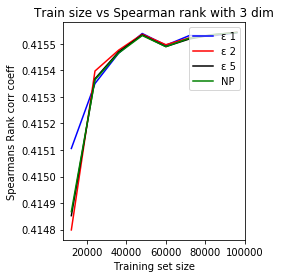

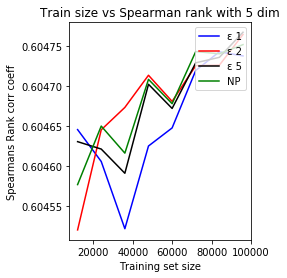

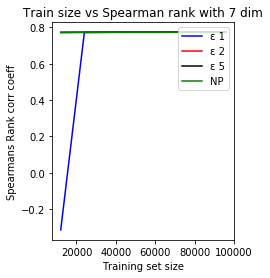

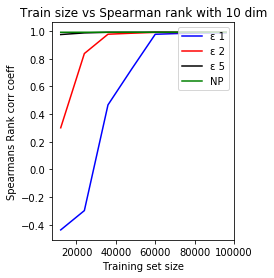

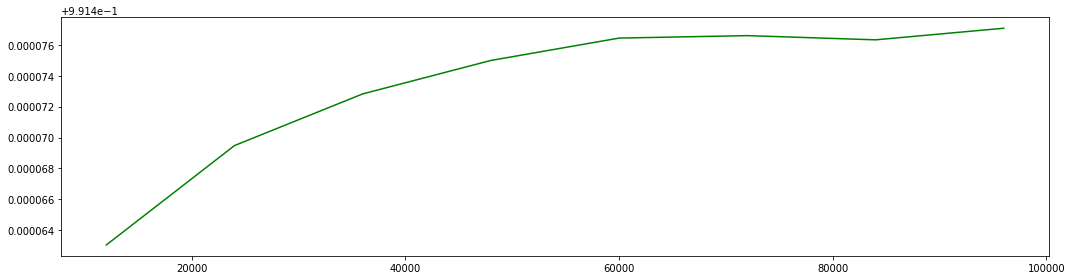

In [32]:
# plotnum = 1
# for i in range(len(entries)):
#     n = entries[i]
#     jump = math.floor(n/pts)
#     for j in range(len(features)):
#         d = features[j]
#         plt.rcParams['figure.figsize'] = (15, 4)
#         plt.subplot(len(entries),len(features),plotnum)
#         for eps_idx in range(len(eps)):
#             epsilon = eps[eps_idx]
#             ans = priv_plotter(X, y, n, d, k, epsilon, jump, 10, 1, 1)
            
#             if epsilon==1:
#                 spearman_ans_withoutDR_e1 = ans
#             if epsilon==2:
#                 spearman_ans_withoutDR_e2 = ans
            
#             plt.errorbar(ans[0], ans[5], color=colors[eps_idx], ecolor=colors[eps_idx], capsize=3, label='ε '+str(epsilon))
        
#         plt.xlabel("Training set size")
#         plt.errorbar(ans[0], ans[6], color="green", ecolor="green", capsize=3, label='NP')
#         plt.ylabel("Spearmans Rank corr coeff")
#         pylab.legend(loc='upper right')
#         plt.title("Train size vs Spearman rank with " + str(d) + " dim")
        
#         plotnum = plotnum+1
          
#     plt.errorbar(ans[0], ans[6], color="green", ecolor="green", label="NP")
#     plt.tight_layout()
#     plt.show()  

# Plot Spearmans Rank corr coeff vs Privacy budget

In [33]:
# plt.rcParams['figure.figsize'] = (7, 6)
# plotnum = 1

# eps = [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 1, 1.5]
# y_axis = np.ones((len(eps)))

# for eps_idx in range(len(eps)):
#     epsilon = eps[eps_idx]
#     ans = priv_plotter(X, y, n, d, k, epsilon, jump, 10, 1, 1)
#     y_axis[eps_idx] = ans[5][ans.shape[1]-1]

# plt.plot(eps, y_axis)
# plt.xlabel("Privacy budget")
# plt.ylabel("Spearmans rank corr coeff")
# plt.title("privacy budget vs Spearman's rank corr coeff n= " + str(n) + " d= " + str(d))
# plt.tight_layout()
# plt.show()

# eps = [1, 2, 5]

KeyboardInterrupt: 

# Implement PCA

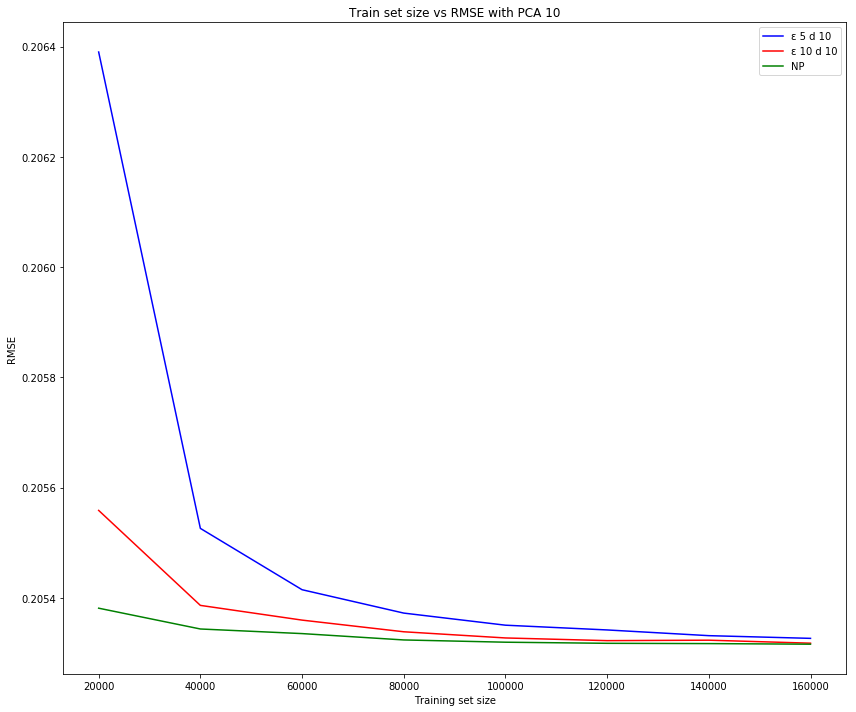

(3, 8)
(3, 8)


In [46]:
from sklearn.decomposition import PCA

def getPCA(d, X):
    pca = PCA(n_components=d)
    x_pca = pca.fit_transform(X)
    return x_pca

reduced_d = [10]
entries = [200000]
plotnum = 1
eps = [5, 10]

pts = 10
x_priv_plots_PCA = np.ones((0, pts))
y_priv_plots_PCA = np.ones((0, pts))


for i in range(len(reduced_d)):
    d = reduced_d[i]   
    x_pca = getPCA(d, X)
    for j in range(len(entries)):
        n = entries[j]
        jump = math.floor(n/pts)
        plt.rcParams['figure.figsize'] = (12,10)
        plt.subplot(len(reduced_d),len(entries),plotnum)
        
        for eps_idx in range(len(eps)):
            epsilon = eps[eps_idx]
            ans = priv_plotter(x_pca, y, n, d, k, epsilon, jump, 10, 1, 1)
            
            if epsilon==5:
                ans_PCA_e5_d10 = ans
            if epsilon==10:
                ans_PCA_e10_d10 = ans
            
            if x_priv_plots_PCA.shape[0] == 0:
                x_priv_plots_PCA = ans[0]
                y_priv_plots_PCA = ans[1]
                
            else:
                x_priv_plots_PCA = np.append(arr=x_priv_plots_PCA, values=ans[0], axis=0)
                y_priv_plots_PCA = np.append(arr=y_priv_plots_PCA, values=ans[1], axis=0)
    
            plt.errorbar(ans[0], ans[1], color=colors[eps_idx], ecolor=colors[eps_idx], capsize=3, label='ε '+str(epsilon)+ " d "+str(d))
 
        x_priv_plots_PCA = np.append(arr=x_priv_plots_PCA, values=ans[0], axis=0)
        y_priv_plots_PCA = np.append(arr=y_priv_plots_PCA, values=ans[3], axis=0)
        
        plt.errorbar(ans[0], ans[3], color=colors[4], ecolor=colors[4], capsize=3, label="NP")
        plt.xlabel("Training set size")
        plt.ylabel("RMSE")
        pylab.legend(loc='upper right')
        plt.title("Train set size vs RMSE with PCA " + str(d))
        plotnum = plotnum+1
        
    plt.tight_layout()
    plt.show()

x_priv_plots_PCA = x_priv_plots_PCA.reshape(len(reduced_d)*len(entries)*(1+len(eps)), len(ans[0]))
y_priv_plots_PCA = y_priv_plots_PCA.reshape(len(reduced_d)*len(entries)*(1+len(eps)), len(ans[0]))
print(x_priv_plots_PCA.shape)
print(y_priv_plots_PCA.shape)

# Dimensionality reduction with VAE

In [47]:
# import tensorflow as tf
# from sklearn.datasets import make_regression
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd
# from sklearn.datasets import make_regression
# import math
# from sklearn.preprocessing import normalize
# import pylab

# X,y = make_regression(n_samples = 10000, n_features=100, noise=0)

# # Parameters for Neural Networks
# learning_param = 0.00001
# epochs = 100
# batch_size = 50

# initial_dimension = 100
# # encoder/decoder dimension
# NN_dimension = 50

# # z dimension - reduce features to:
# latent_variable_dimension = 10

# # Xavier initialisation 
# def xavier(input_shape):
#   val = tf.random_normal(shape = input_shape, stddev = 1./tf.sqrt(input_shape[0]/2.))
#   return val


# #Weight and bias dictionaries

# weight = {  "encoder_weights": tf.Variable(xavier([initial_dimension, NN_dimension])),
#             "mean_weights": tf.Variable(xavier([NN_dimension, latent_variable_dimension])),
#             "std_weights": tf.Variable(xavier([NN_dimension, latent_variable_dimension])),
#             "decoder_weights": tf.Variable(xavier([latent_variable_dimension, NN_dimension])),
#             "output_weights": tf.Variable(xavier([NN_dimension, initial_dimension]))
#          }

# bias = {    "encoder_bias": tf.Variable(xavier([NN_dimension])),
#             "mean_bias": tf.Variable(xavier([latent_variable_dimension])),
#             "std_bias": tf.Variable(xavier([latent_variable_dimension])),
#             "decoder_bias": tf.Variable(xavier([NN_dimension])),
#             "output_bias": tf.Variable(xavier([initial_dimension]))
#        }


# #Encoder Section

# input_X = tf.placeholder(tf.float32, shape = [None, initial_dimension])
# encoder_layer = tf.add(tf.matmul(input_X, weight["encoder_weights"]), bias["encoder_bias"])
# # Apply non linearity - could be sigmoid or tanh or something else
# encoder_layer = tf.nn.tanh(encoder_layer)

# mean_layer = tf.add(tf.matmul(encoder_layer, weight["mean_weights"]), bias["mean_bias"])
# std_layer = tf.add(tf.matmul(encoder_layer, weight["std_weights"]), bias["std_bias"])

# # Reparametrization trick
# epsilon = tf.random_normal(tf.shape(std_layer), dtype = tf.float32, mean = 0.0, stddev = 1.0)
# latent_layer = mean_layer + tf.exp(0.5*std_layer)*epsilon

# # Decoder Section

# decoder_layer = tf.add(tf.matmul(latent_layer, weight["decoder_weights"]), bias["decoder_bias"])
# decoder_layer = tf.nn.tanh(decoder_layer)

# # Output

# output_layer = tf.add(tf.matmul(decoder_layer, weight["output_weights"]), bias["output_bias"])
# output_layer = tf.nn.sigmoid(output_layer)


# #DEFINING LOSS FUNCTION
# # Total Loss = alpha*reconstruction_loss or data_fidelity_loss + beta*KL_divergence_loss
# # alpha and beta = 1 for VAE
# def loss_function(original_X, reconstructed_X):
  
#   # Reconstruction loss
#   # Reconstruction loss = - sum(x*log(X) + (1-x) log(1-X))
  
#   reconst_loss = original_X*tf.log(1e-10 + reconstructed_X) + (1-original_X)*tf.log(1e-10 + 1 - reconstructed_X)
#   reconst_loss = tf.reduce_sum(reconst_loss, 1)
  
#   # KL Divergence loss
#   # KL_loss = 0.5*sum(e^std + mean^2 - 1 - std)
#   KL_div_loss = 1 + std_layer - tf.exp(std_layer) - tf.square(mean_layer)
#   KL_div_loss = -0.5 * tf.reduce_sum(KL_div_loss, 1)
  
#   alpha = 1
#   beta = 1
#   network_loss = tf.reduce_mean(alpha*reconst_loss + beta*KL_div_loss)
#   return network_loss


# loss_value = loss_function(input_X, output_layer)
# optimizer = tf.train.AdamOptimizer(learning_param).minimize(loss_value)

  
# # Initialize all the variables
# init = tf.global_variables_initializer()

# #Start session
# sess = tf.Session()
# # tf.test.is_gpu_available()

# # Run initializer
# sess.run(init)
    
# for epoch in range(epochs):

#     # Loop over all batches
#     for i in range(200):

#       x_batch = X[i*batch_size: (i+1)*batch_size]
#       _, c = sess.run([optimizer, loss_value], feed_dict={input_X: x_batch})

#     # Display logs per epoch step
#     if epoch % 10 == 0:
#         print("Epoch: ", '%02d' % (epoch + 1), "cost = ", "{:.9f}".format(c))
# print("Optimization Finished!")

# # Autoencoder_output = sess.run(Encoder_op, feed_dict={X: inputData})
# # inputData_ae_nl, outputData_ae_nl = normalizeData(Autoencoder_output, outputData, n, d)

In [50]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

initial_dim = 100
intermediate_dim = 50
latent_dim = 10

batch_size = 128
epochs = 50


def z_sampling(args):

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


input_X = Input(shape=(initial_dim, ), name='encoder_input')

# Encoder
x = Dense(intermediate_dim)(input_X)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# Z Sampling using reparametrization trick
z = Lambda(z_sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(input_X, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# Decoder

latent_inputs = Input(shape=(latent_dim,), name='z_sample')
x = Dense(intermediate_dim)(latent_inputs)
output_X = Dense(initial_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, output_X, name='decoder')
decoder.summary()

# instantiate VAE model
output_X = decoder(encoder(input_X)[2])
vae = Model(input_X, output_X, name='vae_mlp')


MSE = True
tr_size = math.floor(4*n/5)
# print(tr_size)
x_train = np.asarray(X[:tr_size])
y_train = np.asarray(y[:tr_size])
x_test = np.asarray(X[tr_size:])
y_test = np.asarray(y[tr_size:])


models = (encoder, decoder)
test_data = (x_test, y_test)

# VAE loss = mse_loss or reconst_loss + kl_loss
if MSE:
    reconstruction_loss = mse(input_X, output_X)
else:
    reconstruction_loss = binary_crossentropy(input_X, output_X)

# reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)

kl_loss = -0.5 * K.sum(kl_loss, axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
vae.fit(x_train,epochs=epochs,batch_size=batch_size,validation_data=(x_test, None))


z_gen = encoder.predict(np.asarray(X))
z_gen = np.asarray(z_gen)
z_generated = z_gen[2]
print(z_generated.shape)
print(len(z_generated))
# z_vae = []
# for i in range(len(z_generated)):
#     z_vae.append(z_generated[i])

jump = math.floor(n/10)
ans_VAE_e5_d10 = priv_plotter(z_generated, y, n, 10, k, 5, jump, 10, 1, 1)
ans_VAE_e10_d10 = priv_plotter(z_generated, y, n, 10, k, 10, jump, 10, 1, 1)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 100)          0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 50)           5050        encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 10)           510         dense_6[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 10)           510         dense_6[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

InternalError: cudaGetDevice() failed. Status: CUDA driver version is insufficient for CUDA runtime version

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import keras.backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Dense, Flatten, Reshape, Dropout, Lambda
from keras.layers.merge import Concatenate
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta, Adamax, Nadam
from keras.utils import Progbar

# Setting some NN Params
initial_dim = 100
intermediate_dim = 50
latent_dim = 10
epochs = 200
batch_size = 512
final_dim = 100
realData = X
lr = 0.0001

In [52]:
cudaRuntimeGetVersion()

NameError: name 'cudaRuntimeGetVersion' is not defined

In [ ]:
def create_x_generator():
  
  x_input = Input(shape=(latent_dim, ))
  
  # Dropout for Regularization
  x = Dropout(0.2)(x_input)
  x = Dense(intermediate_dim)(x)
  output = Dense(initial_dim)(x)
  
  x_gen_model = Model(x_input, output, name='xGenerator')
#   x_gen_model.summary()
  
  return x_gen_model

def create_z_generator():
  
  z_input = Input(shape=(initial_dim, ))
  
  # Dropout for Regularization
  z = Dropout(0.2)(z_input)
  z = Dense(intermediate_dim)(z)
  output = Dense(latent_dim)(z)
  
  z_gen_model = Model(z_input, output, name='zGenerator')
#   z_gen_model.summary()
  
  return z_gen_model


def create_discriminator():
  
  x_input = Input(shape=(initial_dim, ))
  z_input = Input(shape=(latent_dim, ))
  
  # Dropout for Regularization
  x = Dropout(0.1)(x_input)
  z = Dropout(0.1)(z_input)
  
  x = Dense(10)(x)
  z = Dense(10)(z)
  
  concatenated = Concatenate(axis=-1)([x, z])
  output = Dropout(0.5)(concatenated)
  output = Dense(1)(output)
  
  discriminator_model = Model([x_input, z_input], output, name='discriminator')
#   discriminator_model.summary()
  
  return discriminator_model
  
  
def create_ALIGAN(x_generator, z_generator, discriminator):
#   print("a")
  x_input = Input(shape=(initial_dim, ))
  z_input = Input(shape=(latent_dim, ))
  
  x_gen = x_generator(z_input)
  z_gen = z_generator(x_input)
  
  p = discriminator([x_gen, z_input])
  q = discriminator([x_input, z_gen])
  
  output = Concatenate(axis=-1)([p, q])
  aligan_model = Model([x_input, z_input], output, name='aligan')
  return aligan_model
  

def d_lossfun(y_true, y_pred):
    # Clip is to make sure p and q stays in the particular interval
    p = K.clip(y_pred[:,0], K.epsilon(), 1.0 - K.epsilon())
    q = K.clip(y_pred[:,1], K.epsilon(), 1.0 - K.epsilon())
    return -K.mean(K.log(q) + K.log(1. - p))
  
def g_lossfun(y_true, y_pred):
    # Clip is to make sure p and q stays in the particular interval
    p = K.clip(y_pred[:,0], K.epsilon(), 1.0 - K.epsilon())
    q = K.clip(y_pred[:,1], K.epsilon(), 1.0 - K.epsilon())
    return -K.mean(K.log(1. - q) + K.log(p))
  
def reconstruct_latent_points(x,xgen,zgen):
    z_gen = zgen.predict_on_batch(x)
    return z_gen

def generate_data(xgen):
    num_generate_pts = 100
    z_dim = xgen.input_shape[-1]
    z = np.random.normal(size=(num_generate_pts, latent_dim))
    x_gen = xgen.predict_on_batch(z)
    return x_gen
  

In [ ]:
xgen = create_x_generator()
zgen = create_z_generator()
disc = create_discriminator()
opt_d = Adam(lr=lr, beta_1=0.9, beta_2=0.999, decay=0.0)
opt_g = Adam(lr=lr, beta_1=0.9, beta_2=0.999, decay=0.0)

xgen.trainable = False
zgen.trainable = False
disc.trainable = True
gan_d = create_ALIGAN(xgen, zgen, disc)
gan_d.compile(optimizer=opt_d, loss=d_lossfun)
# gan_d.summary()

xgen.trainable = True
zgen.trainable = True
disc.trainable = False
gan_g = create_ALIGAN(xgen, zgen, disc)
gan_g.compile(optimizer=opt_g, loss=g_lossfun)
# gan_g.summary()


# =====================================
# Training Loop
# =====================================
tr_size = math.floor(4*n/5)
num_train = len(realData)
for epoch in range(epochs):
    print('Epochs %d/%d' % (epoch+1, epochs))
    pbar = Progbar(num_train)
    for i in range(0, tr_size, batch_size):
        x = realData[i:i+batch_size]
        z = np.random.normal(size=(len(x), latent_dim))
        # train discriminator
        d_loss = gan_d.train_on_batch([x, z], np.zeros((len(x), 1)))
        # train generators
        g_loss = gan_g.train_on_batch([x, z], np.zeros((len(x), 1)))
        # update progress bar
        pbar.add(len(x), values=[
            ('d_loss', d_loss),
            ('g_loss', g_loss),
        ])



    

In [ ]:
latent_vector = zgen.predict(realData)
print(latent_vector.shape)
jump = math.floor(n/pts)
ans_ALI_e5_d10 = priv_plotter(latent_vector, y, n, 10, k, 5, jump, rep, 1, 1)
ans_ALI_e10_d10 = priv_plotter(latent_vector, y, n, 10, k, 10, jump, rep, 1, 1)


plt.rcParams['figure.figsize'] = (8,6)
plt.errorbar(ans_ALI_e5_d10[0], ans_ALI_e5_d10[1], color="red", ecolor="red", capsize=3, label='ε 5 d 10')
plt.errorbar(ans_ALI_e5_d10[0], ans_ALI_e5_d10[3], color="green", ecolor="green", capsize=3, label='NP')
plt.errorbar(ans_ALI_e10_d10[0], ans_ALI_e10_d10[1], color="blue", ecolor="blue", capsize=3, label='ε 10 d 10')
plt.xlabel("Training set size")
plt.ylabel("RMSE")
pylab.legend(loc='upper right')
plt.title("Train set size vs RMSE with ALI 10 ")
plt.show()


# Plotting


In [ ]:
plt.rcParams['figure.figsize'] = (15, 12)

plt.subplot(3,2,1)
plt.rcParams['figure.figsize'] = (15, 12)
plt.errorbar(ans_withoutDR_e5[0], ans_withoutDR_e5[3], color="green", ecolor="green", capsize=3, label="NP d100 no DR", ls="dashed")
plt.errorbar(ans_withoutDR_e5[0], ans_withoutDR_e5[1], color="red", ecolor="red", capsize=3, label="e0.5 d100 no DR", ls="dashed")
plt.errorbar(ans_withoutDR_e10[0], ans_withoutDR_e10[1], color="blue", ecolor="blue", capsize=3, label="e1 d100 no DR", ls="dashed")

plt.errorbar(ans_PCA_e5_d10[0], ans_PCA_e5_d10[3], color="black", ecolor="black", capsize=3, label="NP d10 PCA", ls="solid")
plt.errorbar(ans_PCA_e5_d10[0], ans_PCA_e5_d10[1], color="orange", ecolor="orange", capsize=3, label="e0.5 d10 PCA", ls="solid")
plt.errorbar(ans_PCA_e10_d10[0], ans_PCA_e10_d10[1], color="purple", ecolor="purple", capsize=3, label="e1 d10 PCA", ls="solid")

plt.xlabel("Training set size")
plt.ylabel("RMSE")
pylab.legend(loc='upper right')
plt.title("Train set size vs RMSE with 100 features - no Dim. Reduction and PCA")
# plt.show()

plt.subplot(3,2,2)
plt.rcParams['figure.figsize'] = (15, 12)
plt.errorbar(ans_withoutDR_e5[0], ans_withoutDR_e5[3], color="green", ecolor="green", capsize=3, label="NP d100 no DR", ls="dashed")
plt.errorbar(ans_withoutDR_e5[0], ans_withoutDR_e5[1], color="red", ecolor="red", capsize=3, label="e0.5 d100 no DR", ls="dashed")
plt.errorbar(ans_withoutDR_e10[0], ans_withoutDR_e10[1], color="blue", ecolor="blue", capsize=3, label="e1 d100 no DR", ls="dashed")

plt.errorbar(ans_VAE_e5_d10[0], ans_VAE_e5_d10[3], color="cyan", ecolor="cyan", capsize=3, label="NP d10 VAE", ls="solid")
plt.errorbar(ans_VAE_e5_d10[0], ans_VAE_e5_d10[1], color="brown", ecolor="brown", capsize=3, label="e0.5 d10 VAE", ls="solid")
plt.errorbar(ans_VAE_e10_d10[0], ans_VAE_e10_d10[1], color="magenta", ecolor="magenta", capsize=3, label="e1 d10 VAE", ls="solid")

plt.xlabel("Training set size")
plt.ylabel("RMSE")
pylab.legend(loc='upper right')
plt.title("Train set size vs RMSE with 100 features - no Dim. Reduction and VAE")
# plt.show()

plt.subplot(3,2,3)
plt.rcParams['figure.figsize'] = (15, 12)
plt.errorbar(ans_withoutDR_e5[0], ans_withoutDR_e5[3], color="green", ecolor="green", capsize=3, label="NP d100 no DR", ls="dashed")
plt.errorbar(ans_withoutDR_e5[0], ans_withoutDR_e5[1], color="red", ecolor="red", capsize=3, label="e0.5 d100 no DR", ls="dashed")
plt.errorbar(ans_withoutDR_e10[0], ans_withoutDR_e10[1], color="blue", ecolor="blue", capsize=3, label="e1 d100 no DR", ls="dashed")

plt.errorbar(ans_ALI_e5_d10[0], ans_ALI_e5_d10[3], color="cyan", ecolor="cyan", capsize=3, label="NP d10 ALI", ls="solid")
plt.errorbar(ans_ALI_e5_d10[0], ans_ALI_e5_d10[1], color="brown", ecolor="brown", capsize=3, label="e0.5 d10 ALI", ls="solid")
plt.errorbar(ans_ALI_e10_d10[0], ans_ALI_e10_d10[1], color="magenta", ecolor="magenta", capsize=3, label="e1 d10 ALI", ls="solid")

plt.xlabel("Training set size")
plt.ylabel("RMSE")
pylab.legend(loc='upper right')
plt.title("Train set size vs RMSE with 100 features - no Dim. Reduction and ALI")

plt.subplot(3,2,4)
plt.rcParams['figure.figsize'] = (15, 12)
plt.errorbar(ans_withoutDR_e05[0], ans_withoutDR_e05[3], color="green", ecolor="green", capsize=3, label="NP d100 no DR", ls="dashed")

plt.errorbar(ans_ALI_e5_d10[0], ans_ALI_e5_d10[3], color="black", ecolor="black", capsize=3, label="NP d10 ALI", ls="solid")
plt.errorbar(ans_ALI_e5_d10[0], ans_ALI_e5_d10[1], color="0.6", ecolor="0.6", capsize=3, label="e0.5 d10 ALI", ls="solid")
plt.errorbar(ans_ALI_e10_d10[0], ans_ALI_e10_d10[1], color="0.25", ecolor="0.25", capsize=3, label="e1 d10 ALI", ls="solid")

plt.errorbar(ans_PCA_e5_d10[0], ans_PCA_e5_d10[3], color="black", ecolor="black", capsize=3, label="NP d10 PCA", ls="dashed")
plt.errorbar(ans_PCA_e5_d10[0], ans_PCA_e5_d10[1], color="orange", ecolor="orange", capsize=3, label="e0.5 d10 PCA", ls="dashed")
plt.errorbar(ans_PCA_e10_d10[0], ans_PCA_e10_d10[1], color="purple", ecolor="purple", capsize=3, label="e1 d10 PCA", ls="dashed")

plt.errorbar(ans_VAE_e5_d10[0], ans_VAE_e5_d10[3], color="cyan", ecolor="cyan", capsize=3, label="NP d10 VAE", ls="solid")
plt.errorbar(ans_VAE_e5_d10[0], ans_VAE_e5_d10[1], color="brown", ecolor="brown", capsize=3, label="e0.5 d10 VAE", ls="solid")
plt.errorbar(ans_VAE_e10_d10[0], ans_VAE_e10_d10[1], color="magenta", ecolor="magenta", capsize=3, label="e1 d10 VAE", ls="solid")

plt.xlabel("Training set size")
plt.ylabel("RMSE")
pylab.legend(loc='upper right')
plt.title("Train set size vs RMSE with 100 features - no Dim. Reduction NP(green) + VAE + PCA + ALI")



plt.subplot(3,2,5)
plt.rcParams['figure.figsize'] = (15, 12)
plt.errorbar(ans_withoutDR_e05[0], ans_withoutDR_e05[3], color="green", ecolor="green", capsize=3, label="NP d100 no DR", ls="dashed")

plt.errorbar(ans_ALI_e5_d10[0], ans_ALI_e5_d10[3], color="black", ecolor="black", capsize=3, label="NP d10 ALI", ls="solid")
plt.errorbar(ans_ALI_e5_d10[0], ans_ALI_e5_d10[1], color="0.6", ecolor="0.6", capsize=3, label="e0.5 d10 ALI", ls="solid")
plt.errorbar(ans_ALI_e10_d10[0], ans_ALI_e10_d10[1], color="0.25", ecolor="0.25", capsize=3, label="e1 d10 ALI", ls="solid")

plt.errorbar(ans_VAE_e5_d10[0], ans_VAE_e5_d10[3], color="cyan", ecolor="cyan", capsize=3, label="NP d10 VAE", ls="solid")
plt.errorbar(ans_VAE_e5_d10[0], ans_VAE_e5_d10[1], color="brown", ecolor="brown", capsize=3, label="e0.5 d10 VAE", ls="solid")
plt.errorbar(ans_VAE_e10_d10[0], ans_VAE_e10_d10[1], color="magenta", ecolor="magenta", capsize=3, label="e1 d10 VAE", ls="solid")

plt.xlabel("Training set size")
plt.ylabel("RMSE")
pylab.legend(loc='upper right')
plt.title("Train set size vs RMSE with 100 features - no Dim. Reduction NP(green) + VAE + ALI")


plt.subplot(3,2,6)
plt.rcParams['figure.figsize'] = (15, 12)
plt.errorbar(ans_withoutDR_e05[0], ans_withoutDR_e05[3], color="green", ecolor="green", capsize=3, label="NP d100 no DR", ls="dashed")

plt.errorbar(ans_ALI_e5_d10[0], ans_ALI_e5_d10[3], color="black", ecolor="black", capsize=3, label="NP d10 ALI", ls="solid")
plt.errorbar(ans_ALI_e5_d10[0], ans_ALI_e5_d10[1], color="0.6", ecolor="0.6", capsize=3, label="e0.5 d10 ALI", ls="solid")
plt.errorbar(ans_ALI_e10_d10[0], ans_ALI_e10_d10[1], color="0.25", ecolor="0.25", capsize=3, label="e1 d10 ALI", ls="solid")

plt.errorbar(ans_PCA_e5_d10[0], ans_PCA_e5_d10[3], color="black", ecolor="black", capsize=3, label="NP d10 PCA", ls="dashed")
plt.errorbar(ans_PCA_e5_d10[0], ans_PCA_e5_d10[1], color="orange", ecolor="orange", capsize=3, label="e0.5 d10 PCA", ls="dashed")
plt.errorbar(ans_PCA_e10_d10[0], ans_PCA_e10_d10[1], color="purple", ecolor="purple", capsize=3, label="e1 d10 PCA", ls="dashed")

plt.xlabel("Training set size")
plt.ylabel("RMSE")
pylab.legend(loc='upper right')
plt.title("Train set size vs RMSE with 100 features - no Dim. Reduction NP(green) + PCA + ALI")


plt.tight_layout()
plt.show()


plt.rcParams['figure.figsize'] = (15, 12)
plt.errorbar(ans_withoutDR_e05[0], ans_withoutDR_e05[3], color="green", ecolor="green", capsize=3, label="NP d100 no DR", ls="dashed")

plt.errorbar(ans_PCA_e5_d10[0], ans_PCA_e5_d10[3], color="black", ecolor="black", capsize=3, label="NP d10 PCA", ls="dashed")
plt.errorbar(ans_PCA_e5_d10[0], ans_PCA_e5_d10[1], color="orange", ecolor="orange", capsize=3, label="e0.5 d10 PCA", ls="dashed")
plt.errorbar(ans_PCA_e10_d10[0], ans_PCA_e10_d10[1], color="purple", ecolor="purple", capsize=3, label="e1 d10 PCA", ls="dashed")

plt.errorbar(ans_VAE_e5_d10[0], ans_VAE_e5_d10[3], color="cyan", ecolor="cyan", capsize=3, label="NP d10 VAE", ls="solid")
plt.errorbar(ans_VAE_e5_d10[0], ans_VAE_e5_d10[1], color="brown", ecolor="brown", capsize=3, label="e0.5 d10 VAE", ls="solid")
plt.errorbar(ans_VAE_e10_d10[0], ans_VAE_e10_d10[1], color="magenta", ecolor="magenta", capsize=3, label="e1 d10 VAE", ls="solid")

plt.xlabel("Training set size")
plt.ylabel("RMSE")
pylab.legend(loc='upper right')
plt.title("Train set size vs RMSE with 100 features - no Dim. Reduction NP(green) + VAE + PCA")
plt.show()